In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/diploma/celeb_gan/celeba/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 256

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 40

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Lambda Gradient penalty

Lambda = 10.0

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/diploma/celeb_gan/img_align_celeba.zip -d /content/drive/MyDrive/diploma/celeb_gan/celeba

In [7]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [8]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

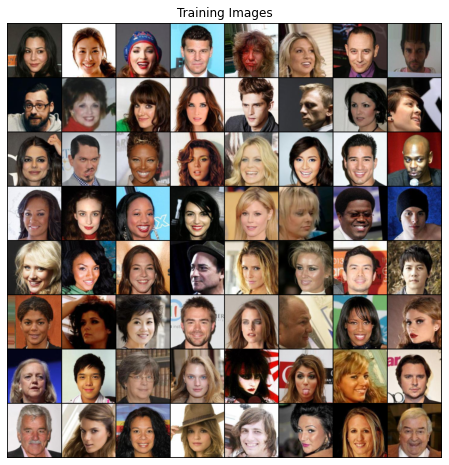

In [9]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
class UpBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.convt = nn.ConvTranspose2d(in_c, out_c, 5, 2, padding=2, output_padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.convt(x)
        out = self.norm(out)
        return self.relu(out)

class DownBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, 5, 2, 2, bias=False)
        self.norm = nn.InstanceNorm2d(out_c, affine=True)
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        return self.lrelu(out)

In [11]:
# Generator Code
class Generator(nn.Module):

    def __init__(self, in_dim=nz, dim=ngf):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())

        self.convts = nn.Sequential(
            UpBlock(dim * 8, dim * 4),
            UpBlock(dim * 4, dim * 2),
            UpBlock(dim * 2, dim),
            UpBlock(dim, dim // 2),
            nn.ConvTranspose2d(dim // 2, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())

        self.init_weight()

    def forward(self, x):
        b = x.size(0)
        out = self.linear(x)
        out = out.view(b, -1, 4, 4)
        out = self.convts(out)
        return out

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                #print('here')
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)


In [12]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.init_weight()

# Print the model
print(netG)

Generator(
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=16384, bias=False)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convts): Sequential(
    (0): UpBlock(
      (convt): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): UpBlock(
      (convt): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): UpBlock(
      (convt): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [15]:
class Discriminator(nn.Module):

    def __init__(self, in_dim=3, dim=ngf):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, dim // 2, 5, 2, 2),
            nn.LeakyReLU(0.2),
            DownBlock(dim//2, dim),
            DownBlock(dim, dim * 2),
            DownBlock(dim * 2, dim * 4),
            DownBlock(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4))

        self.init_weight()

    def forward(self, x):
        y = self.convs(x)
        y = y.view(-1)
        return y

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)

In [16]:
# Create the Discriminator
netD = Discriminator().to(device)

    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.init_weight()

# Print the model
print(netD)

Discriminator(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): DownBlock(
      (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (3): DownBlock(
      (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (4): DownBlock(
      (conv): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (5): DownBlock(
      (conv): Conv2d(512, 1024, kernel

In [17]:
def calc_gradient_penalty(netD, real_data, fake_data):
    # Follows the implementation at: https://github.com/bioinf-jku/TTUR/blob/master/WGAN_GP/gan_64x64_FID.py#L576-L590
    
    # alpha for interpolation
    bs = real_data.shape[0]
    alpha = torch.rand(bs, 1).to(real_data)
    alpha = alpha.expand(bs, real_data.nelement()//bs).contiguous()
    alpha = alpha.view(bs, 3, image_size, image_size)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(real_data),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    # record slopes
    slopes = gradients.norm(2, dim=1)

    gradient_penalty = ((slopes - 1.) ** 2).mean() * Lambda

    return gradient_penalty

In [18]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both  G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
from torch.autograd import Variable

In [20]:
netG.load_state_dict(torch.load('/content/drive/MyDrive/diploma/celeb_gan/wG_e39.pt'))

netD.load_state_dict(torch.load('/content/drive/MyDrive/diploma/celeb_gan/wD_e39.pt'))

<All keys matched successfully>

In [21]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(40, 50):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        for p in netD.parameters(): # update D
            p.requires_grad = True  

        for p in netG.parameters(): # freeze G
            p.requires_grad = False
        
        ############################
        # (1) Update D network

        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        # real
        output = netD(real_cpu)
        errD_real = -output.mean()

        # fake
        noise = torch.randn(b_size, nz, device=device)
        fake = netG(noise)

        errD_fake = netD(fake.detach()).mean()

        gradient_penalty = calc_gradient_penalty(netD, real_cpu, fake)

        # calculate loss for D
        Wasserstein_D = errD_fake + errD_real
        loss_D = Wasserstein_D + gradient_penalty
        loss_D.backward()
        optimizerD.step()


        ############################
        # (2) Update G network
        ###########################

        for p in netG.parameters(): # update G
                p.requires_grad = True

        for p in netD.parameters(): # freeze D
            p.requires_grad = False

        netG.zero_grad()


        noise = torch.randn(b_size, nz, device=device)
        fake = netG(noise)

        errG = netD(fake)
        loss_G = - errG.mean()
        loss_G.backward()

        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print(epoch+1, ', [', i, ' / ', len(dataloader), ']', 'Loss D: ', loss_D.item(), 'Loss g: ', loss_G.item())
        
        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    if (epoch+1) % 5 == 0:
      torch.save(netG.state_dict(), '/content/drive/MyDrive/diploma/celeb_gan/wG_e'+str(epoch)+'.pt')
      torch.save(netD.state_dict(), '/content/drive/MyDrive/diploma/celeb_gan/wD_e'+str(epoch)+'.pt')

Starting Training Loop...
41 , [ 0  /  869 ] Loss D:  -5057.9130859375 Loss g:  21335.4453125
41 , [ 50  /  869 ] Loss D:  -10799.1435546875 Loss g:  36725.0546875
41 , [ 100  /  869 ] Loss D:  -8930.388671875 Loss g:  29976.93359375
41 , [ 150  /  869 ] Loss D:  -12135.923828125 Loss g:  15776.33203125
41 , [ 200  /  869 ] Loss D:  -4149.4521484375 Loss g:  26638.83984375
41 , [ 250  /  869 ] Loss D:  793.2041015625 Loss g:  6135.822265625
41 , [ 300  /  869 ] Loss D:  -15778.9326171875 Loss g:  7101.33740234375
41 , [ 350  /  869 ] Loss D:  -11684.248046875 Loss g:  57508.81640625
41 , [ 400  /  869 ] Loss D:  -11195.802734375 Loss g:  39669.83984375
41 , [ 450  /  869 ] Loss D:  -6376.23046875 Loss g:  33108.86328125
41 , [ 500  /  869 ] Loss D:  -22834.486328125 Loss g:  22817.30078125
41 , [ 550  /  869 ] Loss D:  -4027.4541015625 Loss g:  32065.28125
41 , [ 600  /  869 ] Loss D:  -9836.8857421875 Loss g:  18314.890625
41 , [ 650  /  869 ] Loss D:  -16322.4306640625 Loss g:  54445

In [ ]:
output.shape

torch.Size([18432])

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




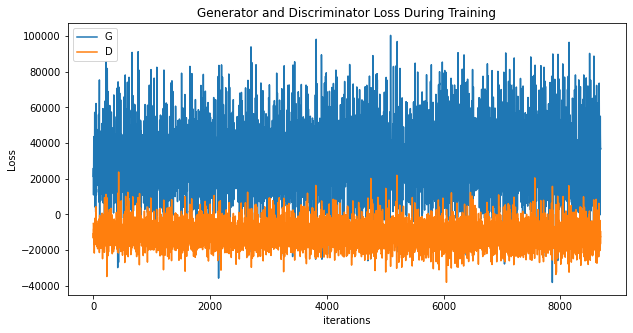

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
#%%capture
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




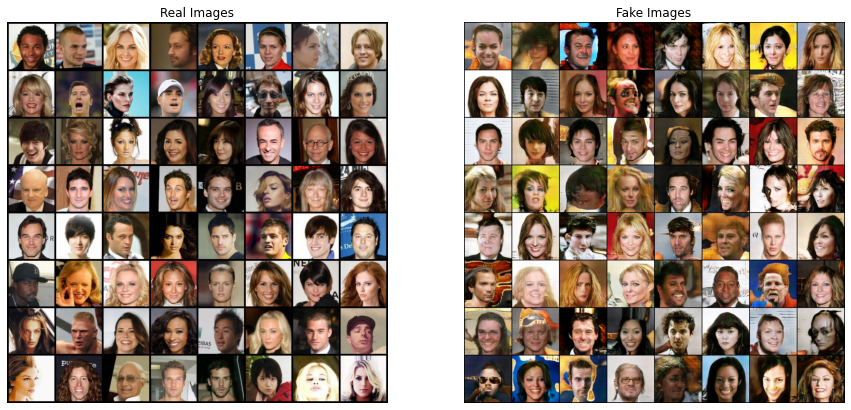

In [24]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

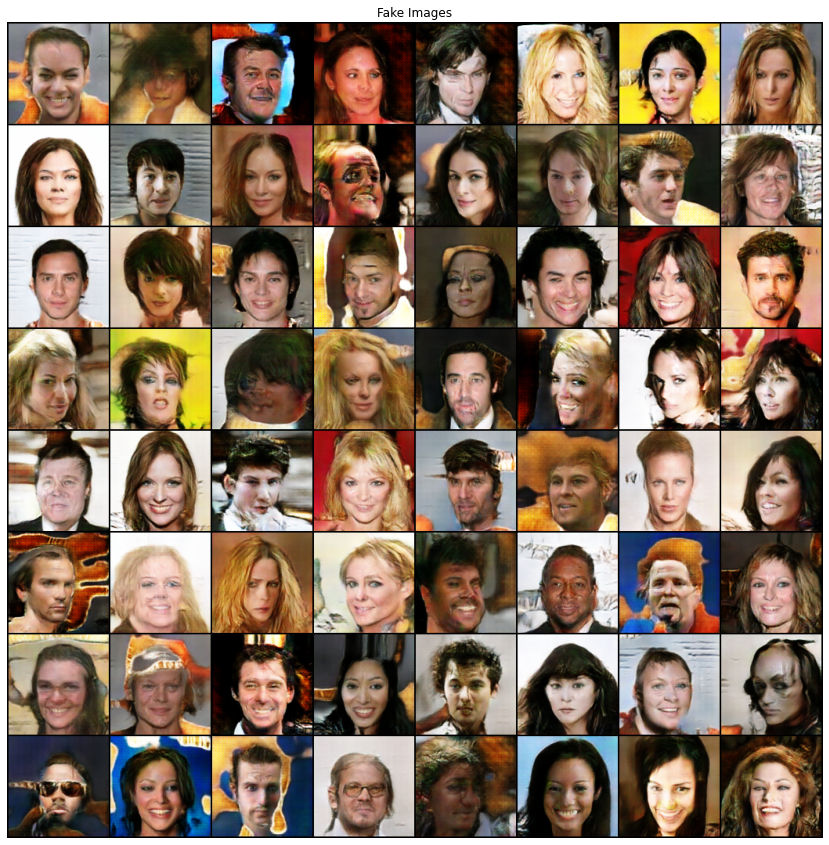

In [25]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()